In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns 
import matplotlib.pyplot as plt
import os

target_dir = "/Users/roucher/Desktop/kaggle/titanicInput"
allowed_extensions = ('.csv', '.txt', '.png', '.jpg') # 过滤文件格式
for dirpath, dirnames, filenames in os.walk (target_dir):
    for filename in filenames:
        if filename.lower().endswith(allowed_extensions):  # 不区分大小写
            full_path = os.path.join(dirpath, filename)
            print(f"[Filtered] {full_path}")

[Filtered] /Users/roucher/Desktop/kaggle/titanicInput/test.csv
[Filtered] /Users/roucher/Desktop/kaggle/titanicInput/train.csv
[Filtered] /Users/roucher/Desktop/kaggle/titanicInput/gender_submission.csv


In [9]:
train1 =  pd.read_csv("titanicInput/train.csv")
test = pd.read_csv("titanicInput/test.csv")

train1['train_test'] = 1
test['train_test'] = 0
test['Survived'] = np.nan
all_data = pd.concat([train1,test])

%matplotlib inline
all_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'train_test'],
      dtype='object')

In [10]:
#quick look at our data types & null counts 
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  train_test   891 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


In [11]:
train1.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,train_test
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.0
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,1.0
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.0
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,1.0
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,1.0
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.0
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.0
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.0


In [12]:
#quick way to separate numeric columns
train1.describe().columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'train_test'],
      dtype='object')

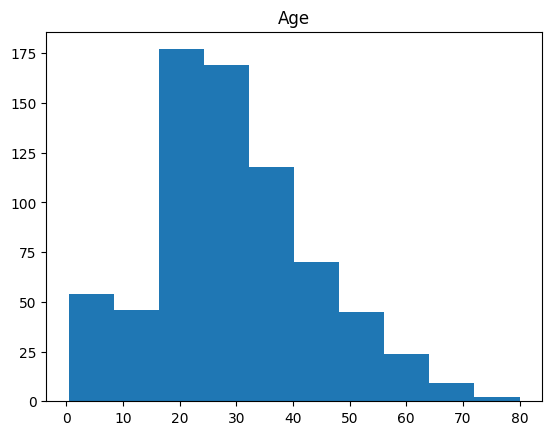

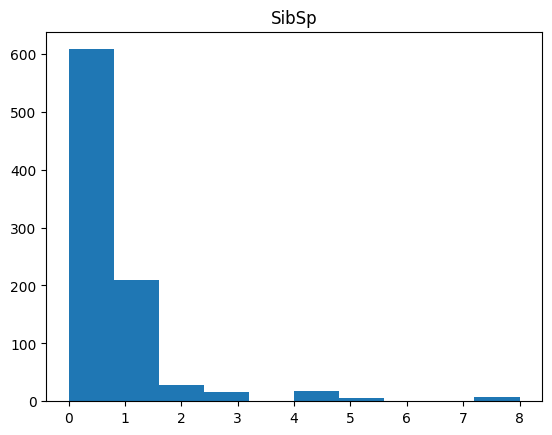

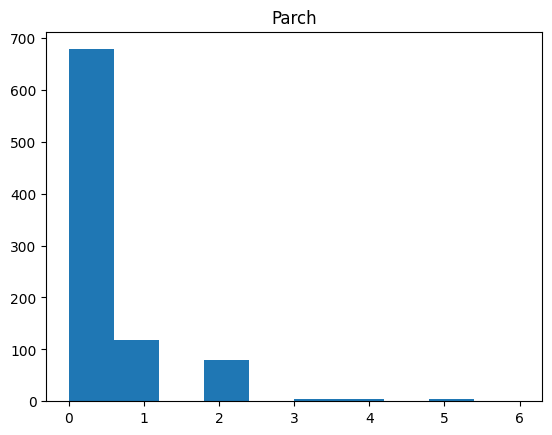

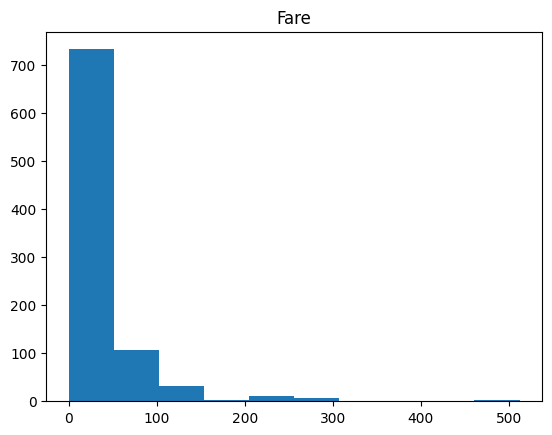

In [13]:
# look at numeric and categorical values separately 
df_num = train1[['Age','SibSp','Parch','Fare']]
df_cat = train1[['Survived','Pclass','Sex','Ticket','Cabin','Embarked']]
#distributions for all numeric variables 
for i in df_num.columns:
    plt.hist(df_num[i])
    plt.title(i)
    plt.show()

In [14]:
# compare survival rate across Age, SibSp, Parch, and Fare 
pd.pivot_table(train1, index = 'Survived', values = ['Age','SibSp','Parch','Fare'])
# Comparing survival and each of these categorical variables 
print(pd.pivot_table(train1, index = 'Survived', columns = 'Pclass', values = 'Ticket' ,aggfunc ='count'))
print()
print(pd.pivot_table(train1, index = 'Survived', columns = 'Sex', values = 'Ticket' ,aggfunc ='count'))
print()
print(pd.pivot_table(train1, index = 'Survived', columns = 'Embarked', values = 'Ticket' ,aggfunc ='count'))

Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119

Sex       female  male
Survived              
0             81   468
1            233   109

Embarked   C   Q    S
Survived             
0         75  47  427
1         93  30  217


### Feature Engineering
1) Cabin - Simplify cabins (evaluated if cabin letter (cabin_adv) or the purchase of tickets across multiple cabins (cabin_multiple) impacted survival)
2) Tickets - Do different ticket types impact survival rates?
3) Does a person's title relate to survival rates?

In [15]:
df_cat.Cabin
train1['cabin_multiple'] = train1.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
# after looking at this, we may want to look at cabin by letter or by number. Let's create some categories for this 
# letters 
# multiple letters 
train1['cabin_multiple'].value_counts()

cabin_multiple
0    687
1    180
2     16
3      6
4      2
Name: count, dtype: int64

In [16]:
pd.pivot_table(train1, index = 'Survived', columns = 'cabin_multiple', values = 'Ticket' ,aggfunc ='count')

#creates categories based on the cabin letter (n stands for null)
#in this case we will treat null values like it's own category
train1['cabin_adv'] = train1.Cabin.apply(lambda x: str(x)[0])

#comparing surivial rate by cabin
print(train1.cabin_adv.value_counts())
pd.pivot_table(train1,index='Survived',columns='cabin_adv', values = 'Name', aggfunc='count')

cabin_adv
n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: count, dtype: int64


cabin_adv,A,B,C,D,E,F,G,T,n
Survived,,,,,,,,,
0,8.0,12.0,24.0,8.0,8.0,5.0,2.0,1.0,481.0
1,7.0,35.0,35.0,25.0,24.0,8.0,2.0,NaN,206.0


understand ticket values better ;

numeric vs non numeric 

In [17]:
train1['numeric_ticket'] = train1.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
train1['ticket_letters'] = train1.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')[:-1]) >0 else 0)

In [18]:
train1['numeric_ticket'].value_counts()

numeric_ticket
1    661
0    230
Name: count, dtype: int64

In [19]:
pd.set_option("display.max_rows", None)
train1['ticket_letters'].value_counts()

#difference in numeric vs non-numeric tickets in survival rate 
pd.pivot_table(train1,index='Survived',columns='numeric_ticket', values = 'Ticket', aggfunc='count')

#survival rate across different tyicket types 
pd.pivot_table(train1,index='Survived',columns='ticket_letters', values = 'Ticket', aggfunc='count')

ticket_letters,0,a4,a5,as,c,ca,casoton,fa,fc,fcc,...,soc,sop,sopp,sotono2,sotonoq,sp,stono2,swpp,wc,wep
Survived,,,,,,,,,,,,,,,,,,,,,
0,410.0,7.0,19.0,1.0,3.0,27.0,1.0,1.0,1.0,1.0,...,5.0,1.0,3.0,2.0,13.0,1.0,10.0,NaN,9.0,2.0
1,255.0,NaN,2.0,NaN,2.0,14.0,NaN,NaN,NaN,4.0,...,1.0,NaN,NaN,NaN,2.0,NaN,8.0,2.0,1.0,1.0


In [20]:
#feature engineering on person's title 
train1.Name.head(50)
train1['name_title'] = train1.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
train1['name_title'].value_counts()

name_title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: count, dtype: int64

In [21]:
train1

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train_test,cabin_multiple,cabin_adv,numeric_ticket,ticket_letters,name_title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.2500,NaN,S,1,0,n,0,a5,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.2833,C85,C,1,1,C,0,pc,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0,n,0,stono2,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.1000,C123,S,1,1,C,1,0,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.0500,NaN,S,1,0,n,1,0,Mr
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,1,0,n,1,0,Mr
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.00,0,0,17463,51.8625,E46,S,1,1,E,1,0,Mr
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.00,3,1,349909,21.0750,NaN,S,1,0,n,1,0,Master
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.00,0,2,347742,11.1333,NaN,S,1,0,n,1,0,Mrs
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.00,1,0,237736,30.0708,NaN,C,1,0,n,1,0,Mrs


### Data Preprocessing for Model

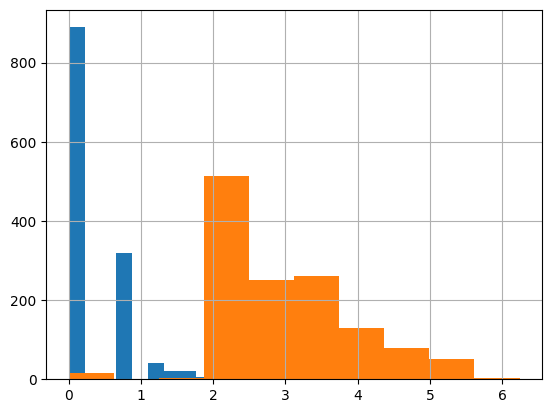

In [22]:
#create all categorical variables that we did above for both training and test sets 
all_data['cabin_multiple'] = all_data.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
all_data['cabin_adv'] = all_data.Cabin.apply(lambda x: str(x)[0])
all_data['numeric_ticket'] = all_data.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
all_data['ticket_letters'] = all_data.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')[:-1]) >0 else 0)
all_data['name_title'] = all_data.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())

all_data['Sex_Pclass'] = all_data['Sex'] + '_' + all_data['Pclass'].astype(str)
all_data['Fare_Pclass'] = all_data['Fare'] * all_data['Pclass'].astype(float)
all_data['Fare_bin'] = pd.qcut(all_data['Fare'], 5, labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#impute nulls for continuous data 
# all_data.Age = all_data.Age.fillna(train1.Age.mean())
all_data['Age'] = all_data.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(x.median()))
all_data.Fare = all_data.Fare.fillna(train1.Fare.mean())

#drop null 'embarked' rows. Only 2 instances of this in training and 0 in test 
all_data.dropna(subset=['Embarked'],inplace = True)

#tried log norm of sibsp (not used)
all_data['norm_sibsp'] = np.log(all_data.SibSp+1)
all_data['norm_sibsp'].hist()

# log norm of fare (used)
all_data['norm_fare'] = np.log(all_data.Fare+1)
all_data['norm_fare'].hist()

# converted fare to category for pd.get_dummies()
all_data.Pclass = all_data.Pclass.astype(str)

#created dummy variables from categories (also can use OneHotEncoder)
all_dummies = pd.get_dummies(all_data[['Pclass','Sex','Age','SibSp','Parch','norm_fare','Embarked','cabin_adv','cabin_multiple','numeric_ticket','name_title','train_test']])

#Split to train test again
x_train = all_dummies[all_dummies.train_test == 1].drop(['train_test'], axis =1)
x_test = all_dummies[all_dummies.train_test == 0].drop(['train_test'], axis =1)

y_train = all_data[all_data.train_test==1].Survived
y_train.shape

# Scale data 
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
all_dummies_scaled = all_dummies.copy()
all_dummies_scaled[['Age','SibSp','Parch','norm_fare']]= scale.fit_transform(all_dummies_scaled[['Age','SibSp','Parch','norm_fare']])
all_dummies_scaled

x_train_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 1].drop(['train_test'], axis =1)
x_test_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 0].drop(['train_test'], axis =1)

y_train = all_data[all_data.train_test==1].Survived

In [23]:
import numpy as np  # 正确给numpy设置别名
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn import tree
from xgboost import XGBClassifier

 usually use Naive Bayes as a baseline for my classification tasks 

In [24]:
gnb = GaussianNB()
cv = cross_val_score(gnb,x_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

lr = LogisticRegression(max_iter = 2000)
cv = cross_val_score(lr,x_train,y_train,cv=5)
print(cv)
print(cv.mean())
lr = LogisticRegression(max_iter = 2000)
cv = cross_val_score(lr,x_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

dt = tree.DecisionTreeClassifier(random_state = 1)
cv = cross_val_score(dt,x_train,y_train,cv=5)
print(cv)
print(cv.mean())
dt = tree.DecisionTreeClassifier(random_state = 1)
cv = cross_val_score(dt,x_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

knn = KNeighborsClassifier()
cv = cross_val_score(knn,x_train,y_train,cv=5)
print(cv)
print(cv.mean())
knn = KNeighborsClassifier()
cv = cross_val_score(knn,x_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())


[0.66853933 0.70224719 0.75842697 0.74719101 0.73446328]
0.7221735542436362
[0.82022472 0.80898876 0.80337079 0.82022472 0.85310734]
0.8211832666793626
[0.82022472 0.80898876 0.80337079 0.82022472 0.85310734]
0.8211832666793626
[0.74719101 0.74157303 0.80898876 0.75842697 0.82485876]
0.776207706468609
[0.74719101 0.74157303 0.80898876 0.75280899 0.81920904]
0.7739541674601662
[0.76966292 0.80898876 0.80337079 0.81460674 0.83615819]
0.8065574811147084
[0.79775281 0.79213483 0.83146067 0.80337079 0.85310734]
0.8155652891512728


In [25]:
rf = RandomForestClassifier(random_state = 1)
cv = cross_val_score(rf,x_train,y_train,cv=5)
print(cv)
print(cv.mean())
rf = RandomForestClassifier(random_state = 1)
cv = cross_val_score(rf,x_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

svc = SVC(probability = True)
cv = cross_val_score(svc,x_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())


[0.82022472 0.78651685 0.85393258 0.73033708 0.84180791]
0.8065638291119152
[0.81460674 0.78651685 0.85393258 0.73033708 0.84180791]
0.8054402336062972
[0.84831461 0.82022472 0.8258427  0.80337079 0.86440678]
0.8324319177299563


In [28]:
xgb = XGBClassifier(random_state =1)
cv = cross_val_score(xgb,x_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators = [('lr',lr),('knn',knn),('rf',rf),('gnb',gnb),('svc',svc),('xgb',xgb)], voting = 'soft') 

cv = cross_val_score(voting_clf,x_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

voting_clf.fit(x_train_scaled,y_train)
y_hat_base_vc = voting_clf.predict(x_test_scaled).astype(int)
basic_submission = {'PassengerId': test.PassengerId, 'Survived': y_hat_base_vc}
base_submission = pd.DataFrame(data=basic_submission)
base_submission.to_csv('base_submission.csv', index=False)

[0.80898876 0.80898876 0.85393258 0.80337079 0.8079096 ]
0.8166381006792356
[0.82022472 0.81460674 0.8258427  0.80337079 0.85875706]
0.8245604011934236


### Grid Search

In [29]:
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 

### LOGISTIC REGRESSION

In [31]:
#simple performance reporting function
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

lr = LogisticRegression()
param_grid = {'max_iter' : [2000],
            'penalty' : ['l1', 'l2'],
            'C' : np.logspace(-4, 4, 20),
            'solver' : ['liblinear']}

clf_lr = GridSearchCV(lr, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_lr = clf_lr.fit(x_train_scaled,y_train)
clf_performance(best_clf_lr,'Logistic Regression')

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Logistic Regression
Best Score: 0.8268075922046594
Best Parameters: {'C': np.float64(1.623776739188721), 'max_iter': 2000, 'penalty': 'l1', 'solver': 'liblinear'}
Fitting 5 folds for each of 48 candidates, totalling 240 fits
KNN
Best Score: 0.8290484352186885
Best Parameters: {'algorithm': 'auto', 'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}


### KNN - K NEAREST NEIGHBOR

In [ ]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors' : [3,5,7,9],
            'weights' : ['uniform', 'distance'],
            'algorithm' : ['auto', 'ball_tree','kd_tree'],
            'p' : [1,2]}
clf_knn = GridSearchCV(knn, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_knn = clf_knn.fit(x_train_scaled,y_train)
clf_performance(best_clf_knn,'KNN')

### SVC - SUPPORT VECTOR CLASSIFIER

In [32]:
svc = SVC(probability = True)
param_grid = tuned_parameters = [{'kernel': ['rbf'], 'gamma': [.1,.5,1,2,5,10],'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['linear'], 'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['poly'], 'degree' : [2,3,4,5], 'C': [.1, 1, 10, 100, 1000]}]
clf_svc = GridSearchCV(svc, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_svc = clf_svc.fit(x_train_scaled,y_train)
clf_performance(best_clf_svc,'SVC')

Fitting 5 folds for each of 55 candidates, totalling 275 fits
SVC
Best Score: 0.8324319177299563
Best Parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


### RANDOM FOREST

In [36]:
rf = RandomForestClassifier(random_state = 1)
param_grid =  {'n_estimators': [400,500],
                                'criterion':['gini','entropy'],
                                  'bootstrap': [True],
                                  'max_depth': [15, 20],
                                  'max_features': ['sqrt', 10],
                                  'min_samples_leaf': [2,3],
                                  'min_samples_split': [3,5],
                                  'random_state': [42],
                                  'class_weight': ['balanced']}

clf_rf = GridSearchCV(rf, param_grid = param_grid, 
                    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                    verbose=True, n_jobs=-1)
best_clf_rf = clf_rf.fit(x_train_scaled,y_train)
clf_performance(best_clf_rf,'Random Forest')

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Random Forest
Best Score: 0.8279438837046913
Best Parameters: {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 15, 'max_features': 10, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 400, 'random_state': 42}


/opt/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


RandomForestClassifier(class_weight='balanced', max_depth=15, max_features=10,
                       min_samples_leaf=3, min_samples_split=3,
                       n_estimators=400, random_state=42)

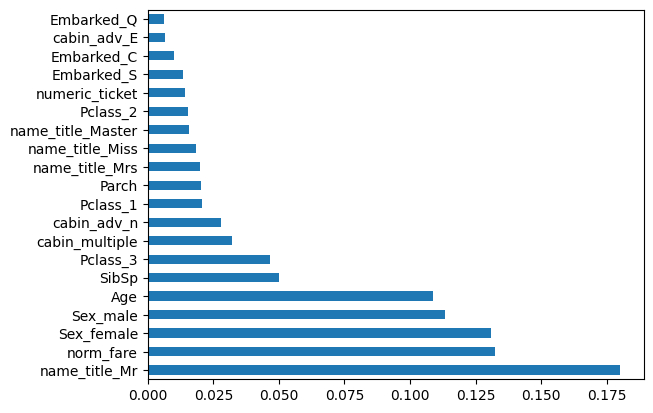

In [37]:
best_rf = best_clf_rf.best_estimator_.fit(x_train_scaled,y_train)
feat_importances = pd.Series(best_rf.feature_importances_, index=x_train_scaled.columns)
feat_importances.nlargest(20).plot(kind='barh')

# 添加特征选择：
from sklearn.feature_selection import SelectFromModel
selector = SelectFromModel(best_rf, prefit=True, threshold='median')
x_train_scaled_selected = selector.transform(x_train_scaled)
x_test_scaled_selected = selector.transform(x_test_scaled)

# 使用选择后的特征重新训练模型
best_rf_selected = RandomForestClassifier(**best_clf_rf.best_params_)
best_rf_selected.fit(x_train_scaled_selected, y_train)

In [38]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_rf_selected, x_train_scaled_selected, y_train, cv=cv)
print("交叉验证分数:", cv_scores)
print("平均分数:", cv_scores.mean())
print("标准差:", cv_scores.std())

交叉验证分数: [0.87640449 0.80898876 0.7752809  0.83707865 0.83050847]
平均分数: 0.8256522567130069
标准差: 0.03330129325000562


In [35]:
xgb = XGBClassifier(random_state = 1)

param_grid = {
    'n_estimators': [450,500,550],
    'colsample_bytree': [0.75,0.8,0.85],
    'max_depth': [None],
    'reg_alpha': [1],
    'reg_lambda': [2, 5, 10],
    'subsample': [0.55, 0.6, .65],
    'learning_rate':[0.5],
    'gamma':[.5,1,2],
    'min_child_weight':[0.01],
    'sampling_method': ['uniform']
}

clf_xgb = GridSearchCV(xgb, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_xgb = clf_xgb.fit(x_train_scaled,y_train)
clf_performance(best_clf_xgb,'XGB')

y_hat_xgb = best_clf_xgb.best_estimator_.predict(x_test_scaled).astype(int)
xgb_submission = {'PassengerId': test.PassengerId, 'Survived': y_hat_xgb}
submission_xgb = pd.DataFrame(data=xgb_submission)
submission_xgb.to_csv('xgb_submission3.csv', index=False)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
XGB
Best Score: 0.8447978162889609
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0.5, 'learning_rate': 0.5, 'max_depth': None, 'min_child_weight': 0.01, 'n_estimators': 550, 'reg_alpha': 1, 'reg_lambda': 5, 'sampling_method': 'uniform', 'subsample': 0.6}


### 改进1:交叉验证结果分析

In [39]:
# 对每个模型进行详细的交叉验证分析
models = {
    'rf': best_clf_rf.best_estimator_,
    'xgb': best_clf_xgb.best_estimator_,
    'svc': best_clf_svc.best_estimator_,
    'lr': best_clf_lr.best_estimator_
}

from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

# 对每个模型进行多指标交叉验证
from sklearn.model_selection import cross_validate
for name, model in models.items():
    cv_results = cross_validate(model, x_train_scaled, y_train, 
                              scoring=scoring, cv=5, return_train_score=True)
    print(f"\n{name} 模型评估结果:")
    print(f"验证集准确率: {cv_results['test_accuracy'].mean():.3f} (+/- {cv_results['test_accuracy'].std()*2:.3f})")
    print(f"验证集精确率: {cv_results['test_precision'].mean():.3f} (+/- {cv_results['test_precision'].std()*2:.3f})")
    print(f"验证集召回率: {cv_results['test_recall'].mean():.3f} (+/- {cv_results['test_recall'].std()*2:.3f})")
    print(f"验证集F1分数: {cv_results['test_f1'].mean():.3f} (+/- {cv_results['test_f1'].std()*2:.3f})")



rf 模型评估结果:
验证集准确率: 0.828 (+/- 0.051)
验证集精确率: 0.787 (+/- 0.054)
验证集召回率: 0.756 (+/- 0.146)
验证集F1分数: 0.769 (+/- 0.085)

xgb 模型评估结果:
验证集准确率: 0.845 (+/- 0.046)
验证集精确率: 0.820 (+/- 0.057)
验证集召回率: 0.762 (+/- 0.101)
验证集F1分数: 0.789 (+/- 0.069)

svc 模型评估结果:
验证集准确率: 0.832 (+/- 0.043)
验证集精确率: 0.813 (+/- 0.059)
验证集召回率: 0.732 (+/- 0.136)
验证集F1分数: 0.768 (+/- 0.079)

lr 模型评估结果:
验证集准确率: 0.827 (+/- 0.033)
验证集精确率: 0.785 (+/- 0.053)
验证集召回率: 0.756 (+/- 0.098)
验证集F1分数: 0.769 (+/- 0.053)


### 2.学习曲线分析

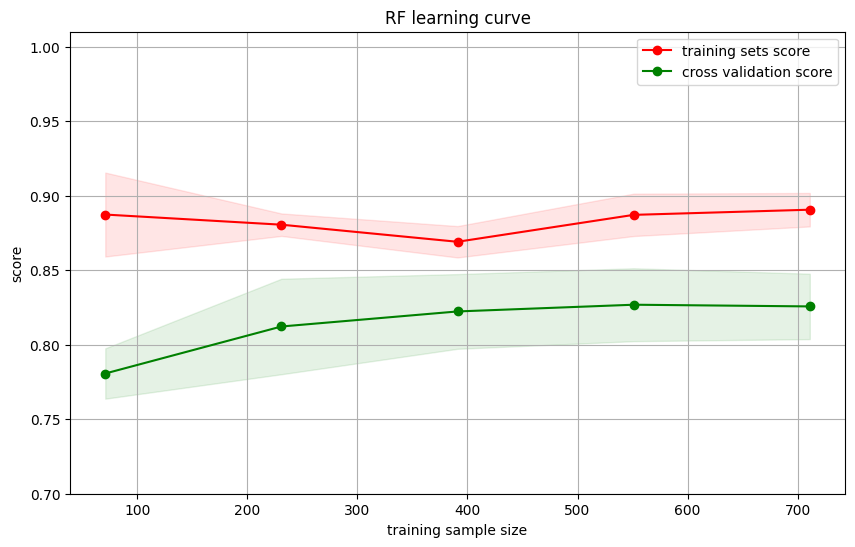

In [48]:
# 绘制学习曲线来分析模型的偏差-方差权衡
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

def plot_learning_curve(estimator, title,X, y, ylim=None, cv=5,
                       n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("training sample size")
    plt.ylabel("score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="training sets score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="cross validation score")
    plt.legend(loc="best")
    return plt

# 为最佳模型绘制学习曲线
plot_learning_curve(best_clf_rf.best_estimator_, 
                   "RF learning curve", 
                   x_train_scaled, y_train, 
                   ylim=(0.7, 1.01), cv=5)
plt.show()

### 改进3:错误分析

错误预测案例分析:
总错误数: 95


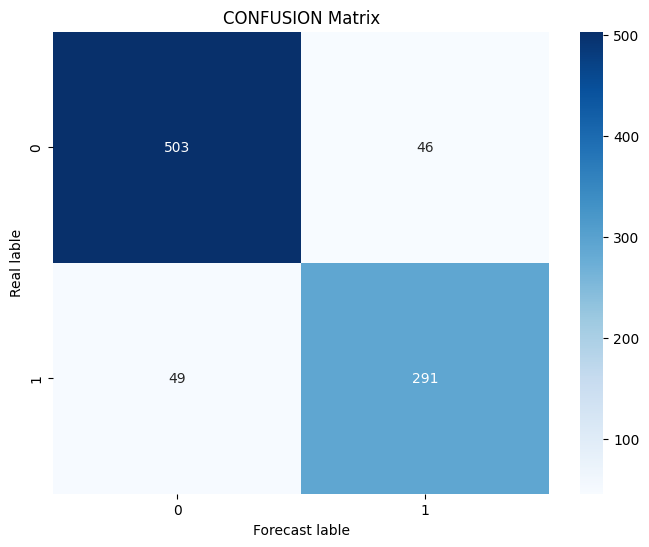

/opt/anaconda3/envs/py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


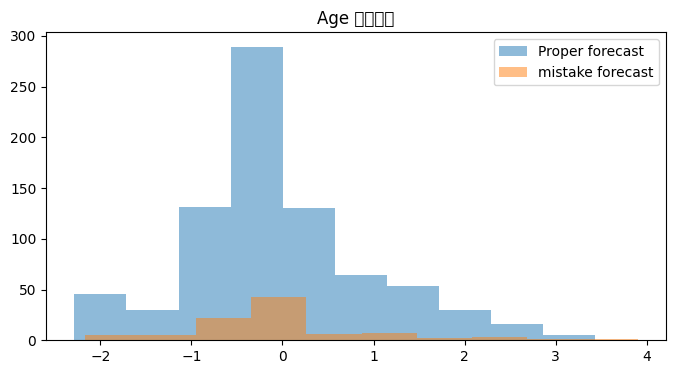

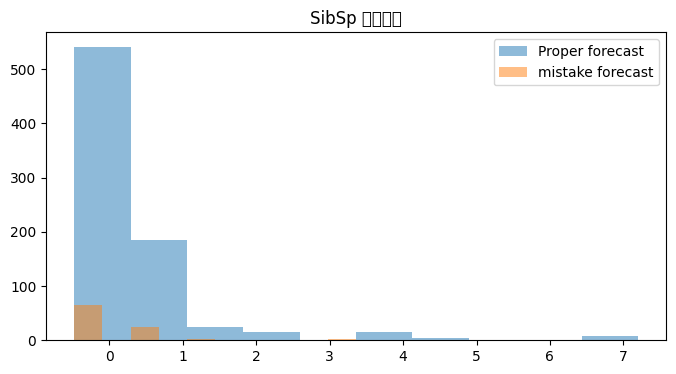

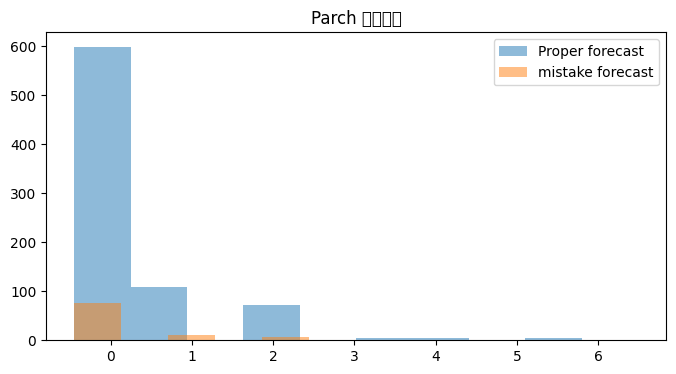

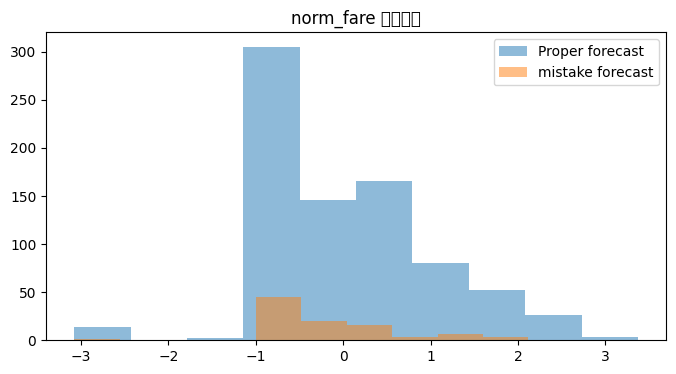

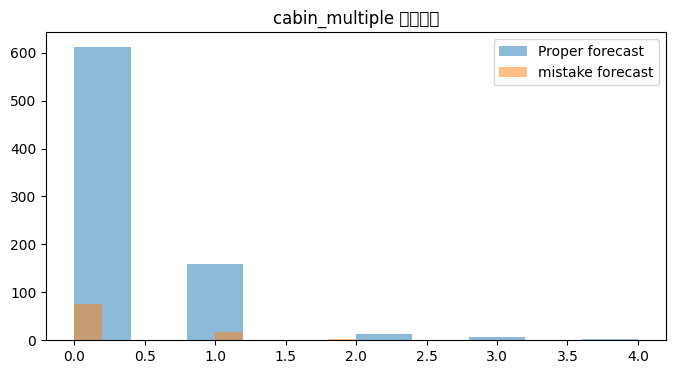

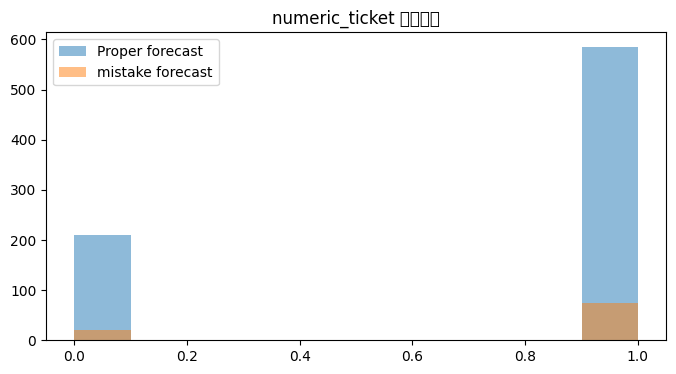

/opt/anaconda3/envs/py310/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7124: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  m, bins = np.histogram(x[i], bins, weights=w[i], **hist_kwargs)


TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

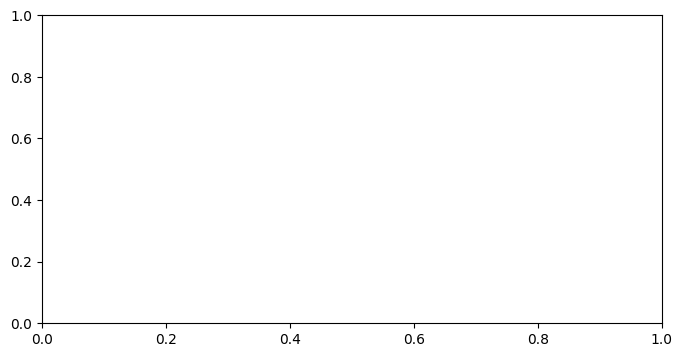

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def analyze_errors(model, X, y, feature_names):
    y_pred = model.predict(X)
    errors = X[y != y_pred]
    true_labels = y[y != y_pred]
    
    print("错误预测案例分析:")
    print(f"总错误数: {len(errors)}")
    
    # 混淆矩阵可视化
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('CONFUSION Matrix')
    plt.ylabel('Real lable')
    plt.xlabel('Forecast lable')
    plt.show()
    
    # 分析错误案例的特征分布
    for feature in feature_names:
        plt.figure(figsize=(8, 4))
        plt.hist(X[y == y_pred][feature], alpha=0.5, label='Proper forecast')
        plt.hist(errors[feature], alpha=0.5, label='mistake forecast')
        plt.title(f'{feature} 分布对比')
        plt.legend()
        plt.show()

# 对最佳模型进行错误分析
analyze_errors(best_clf_rf.best_estimator_, 
              x_train_scaled, 
              y_train, 
              x_train_scaled.columns)


### 改进4:集成策略优化

In [46]:
# 基于交叉验证结果，创建加权投票分类器
from sklearn.ensemble import VotingClassifier

# 根据交叉验证性能为每个模型分配权重
weights = [0.4, 0.3, 0.2, 0.1]  # 根据之前的cv结果调整权重
voting_clf = VotingClassifier(
    estimators=[
        ('rf', best_clf_rf.best_estimator_),
        ('xgb', best_clf_xgb.best_estimator_),
        ('svc', best_clf_svc.best_estimator_),
        ('lr', best_clf_lr.best_estimator_)
    ],
    voting='soft',
    weights=weights
)

# 评估集成模型
cv_results = cross_validate(voting_clf, x_train_scaled, y_train, 
                          scoring=scoring, cv=5)
print("\n集成模型评估结果:")
print(f"准确率: {cv_results['test_accuracy'].mean():.3f} (+/- {cv_results['test_accuracy'].std()*2:.3f})")


集成模型评估结果:
准确率: 0.839 (+/- 0.049)


## 最终预测

In [51]:
# 1. 使用改进后的特征工程处理测试集
test_processed = x_test_scaled.copy()
if 'Sex_Pclass' in x_train_scaled.columns:
    test_processed['Sex_Pclass'] = all_data[all_data.train_test == 0]['Sex'] + '_' + \
                                  all_data[all_data.train_test == 0]['Pclass'].astype(str)
if 'Fare_Pclass' in x_train_scaled.columns:
    test_processed['Fare_Pclass'] = all_data[all_data.train_test == 0]['Fare'] * \
                                   all_data[all_data.train_test == 0]['Pclass'].astype(float)

# 2. 使用特征选择器转换测试数据
test_processed_selected = selector.transform(test_processed)

# 3. 使用集成模型进行预测
# 3.1 获取每个基础模型的预测概率
rf_proba = best_clf_rf.best_estimator_.predict_proba(test_processed_selected)
xgb_proba = best_clf_xgb.best_estimator_.predict_proba(test_processed_selected)
svc_proba = best_clf_svc.best_estimator_.predict_proba(test_processed_selected)
lr_proba = best_clf_lr.best_estimator_.predict_proba(test_processed_selected)

# 3.2 加权平均预测概率
weighted_proba = (0.4 * rf_proba + 
                 0.3 * xgb_proba + 
                 0.2 * svc_proba + 
                 0.1 * lr_proba)

# 3.3 获取最终预测
final_predictions = (weighted_proba[:, 1] >= 0.5).astype(int)

# 4. 创建提交文件
submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': final_predictions
})

# 5. 保存预测结果
submission.to_csv('Final_ensemble_submission.csv', index=False)

# 6. 输出预测结果统计
print("\n最终预测统计:")
print(f"预测存活人数: {final_predictions.sum()}")
print(f"预测死亡人数: {len(final_predictions) - final_predictions.sum()}")
print(f"存活率: {final_predictions.sum() / len(final_predictions):.2%}")

# 7. 预测结果可视化
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.pie([final_predictions.sum(), len(final_predictions) - final_predictions.sum()], 
        labels=['Survived', 'Not Survived'],
        autopct='%1.1f%%')
plt.title('Predicted results Distribution')

plt.subplot(1, 2, 2)
plt.bar(['RF', 'XGB', 'SVC', 'LR'], 
        [0.4, 0.3, 0.2, 0.1],
        alpha=0.8)
plt.title('Model weights Distribution')
plt.ylabel('WEIGHTS')
plt.tight_layout()
plt.show()

/opt/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


ValueError: X has 21 features, but RandomForestClassifier is expecting 41 features as input.

In [53]:
# 1. 确保使用正确的特征集
print("训练集特征:", x_train_scaled.columns.tolist())
print("测试集特征:", x_test_scaled.columns.tolist())

# 2. 使用最佳的随机森林模型进行预测
rf_predictions = best_clf_rf.predict_proba(x_test_scaled)
print("随机森林预测完成")

# 3. 使用最佳的XGBoost模型进行预测
xgb_predictions = best_clf_xgb.predict_proba(x_test_scaled)
print("XGBoost预测完成")

# 4. 使用最佳的SVC模型进行预测
svc_predictions = best_clf_svc.predict_proba(x_test_scaled)
print("SVC预测完成")

# 5. 使用最佳的逻辑回归模型进行预测
lr_predictions = best_clf_lr.predict_proba(x_test_scaled)
print("逻辑回归预测完成")

# 6. 加权集成预测
weighted_predictions = (
    0.4 * rf_predictions + 
    0.3 * xgb_predictions + 
    0.2 * svc_predictions + 
    0.1 * lr_predictions
)

# 7. 转换为最终预测
final_predictions = (weighted_predictions[:, 1] >= 0.5).astype(int)

# 8. 创建提交文件
submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': final_predictions
})

# 9. 保存预测结果
submission.to_csv('ensemble_submission_v2.csv', index=False)

# 10. 输出预测统计
print("\n预测统计:")
print(f"预测存活人数: {final_predictions.sum()}")
print(f"预测死亡人数: {len(final_predictions) - final_predictions.sum()}")
print(f"存活率: {final_predictions.sum() / len(final_predictions):.2%}")

# 11. 对比各个模型的预测差异
model_predictions = {
    'RF': (rf_predictions[:, 1] >= 0.5).astype(int),
    'XGB': (xgb_predictions[:, 1] >= 0.5).astype(int),
    'SVC': (svc_predictions[:, 1] >= 0.5).astype(int),
    'LR': (lr_predictions[:, 1] >= 0.5).astype(int)
}

print("\n各模型预测差异:")
for name, preds in model_predictions.items():
    print(f"{name} 预测存活率: {preds.mean():.2%}")

训练集特征: ['Age', 'SibSp', 'Parch', 'norm_fare', 'cabin_multiple', 'numeric_ticket', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'cabin_adv_A', 'cabin_adv_B', 'cabin_adv_C', 'cabin_adv_D', 'cabin_adv_E', 'cabin_adv_F', 'cabin_adv_G', 'cabin_adv_T', 'cabin_adv_n', 'name_title_Capt', 'name_title_Col', 'name_title_Don', 'name_title_Dona', 'name_title_Dr', 'name_title_Jonkheer', 'name_title_Lady', 'name_title_Major', 'name_title_Master', 'name_title_Miss', 'name_title_Mlle', 'name_title_Mme', 'name_title_Mr', 'name_title_Mrs', 'name_title_Ms', 'name_title_Rev', 'name_title_Sir', 'name_title_the Countess']
测试集特征: ['Age', 'SibSp', 'Parch', 'norm_fare', 'cabin_multiple', 'numeric_ticket', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'cabin_adv_A', 'cabin_adv_B', 'cabin_adv_C', 'cabin_adv_D', 'cabin_adv_E', 'cabin_adv_F', 'cabin_adv_G', 'cabin_adv_T', 'cabin_adv_n', 'name_title_C